<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome11/16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Environment Setup (imports, seed fixing, save path)

import os
import sys
import random
import numpy as np
import pandas as pd

# Reproducibility: fix random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Base save path for results
if "google.colab" in sys.modules:
    from google.colab import drive
    print("\n[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"\n[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("=" * 60)
print("Environment setup complete!")
print(f"Results will be stored in: {base_save_path}")
print("=" * 60)



[INFO] Google Colab detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results
Environment setup complete!
Results will be stored in: /content/drive/MyDrive/geoexosome_results


In [2]:
# Cell 1: Library Installation (optional on Colab) and Imports

# If running on Colab for the first time, uncomment:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

import GEOparse

from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set(style="whitegrid", font_scale=1.2)

print("\n[INFO] All libraries successfully imported.")



[INFO] All libraries successfully imported.


In [3]:
# Cell 2: Load GEO dataset (GSE39833) and preprocess expression matrix

gse_id = "GSE39833"
print(f"\n[INFO] Loading GEO dataset: {gse_id}")

gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Number of GSM samples: {len(gse.gsms)}")
print(f"[INFO] Number of GPL platforms: {len(gse.gpls)}")

# -------------------------------------------------------------
# 1) Extract expression matrix and sample labels
# -------------------------------------------------------------

samples = []
expression_rows = []
labels = []

for gsm_name, gsm in gse.gsms.items():

    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipped.")
        continue

    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # -----------------------------------------------------
    # A) PRIMARY LABELING: Use Sample Title (most reliable)
    # -----------------------------------------------------
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()

    if title.startswith("hc_"):        # Healthy controls
        label_value = 0
    elif title.startswith("crc"):      # CRC patients (CRC1, CRC2, CRC3a, CRC3b, CRC4)
        label_value = 1
    else:
        label_value = None  # Unknown — fallback to metadata parsing

    # -----------------------------------------------------
    # B) FALLBACK: Use metadata characteristics (TNM stage)
    # -----------------------------------------------------
    if label_value is None:
        characteristics = gsm.metadata.get("characteristics_ch1", []) + \
                          gsm.metadata.get("characteristics_ch2", [])
        chars_low = [c.lower() for c in characteristics]

        # Cancer indicators
        if any(("tnm" in c or "stage" in c or "cancer" in c or "adenocarcinoma" in c) for c in chars_low):
            label_value = 1
        # Healthy indicators
        elif any(("healthy" in c or "control" in c or "normal" in c) for c in chars_low):
            label_value = 0
        else:
            raise ValueError(
                f"[ERROR] Could not determine label for {gsm_name}. "
                f"Title: {title_list}, Metadata: {characteristics}"
            )

    labels.append(label_value)

expression_data = np.vstack(expression_rows)

# -------------------------------------------------------------
# 2) Build df_expression DataFrame
# -------------------------------------------------------------
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print("\n[INFO] df_expression overview:")
print("Shape:", df_expression.shape)
print("Label distribution:\n", df_expression["label"].value_counts())

# -------------------------------------------------------------
# 3) Probe → miRNA mapping using GPL
# -------------------------------------------------------------
print("\n[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...")

gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column.")

# Look for a column containing miRNA names
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

if len(mirna_cols) == 0:
    print("[WARNING] No miRNA column detected in GPL. Mapping skipped.")
    mapping_df = None
else:
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: {mirna_col}")

    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    mapping_df = pd.DataFrame({
        "ProbeID": probe_ids,
        "miRNA": mirna_names
    })

    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"[INFO] Probe → miRNA mapping saved to: {mapping_path}")

print("\n[INFO] GSE39833 preprocessing complete.")


16-Nov-2025 08:59:13 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz



[INFO] Loading GEO dataset: GSE39833


100%|██████████| 11.4M/11.4M [00:00<00:00, 25.3MB/s]
16-Nov-2025 08:59:13 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
16-Nov-2025 08:59:13 DEBUG downloader - Moving /tmp/tmpwhynnzs8 to /content/data/GSE39833_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpwhynnzs8 to /content/data/GSE39833_family.soft.gz
16-Nov-2025 08:59:13 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
16-Nov-2025 08:59:13 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
16-Nov-2025 08:59:13 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
16-Nov-2025 08:59:13 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
16-Nov-2025 08:59:13 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATF

[INFO] Number of GSM samples: 99
[INFO] Number of GPL platforms: 1

[INFO] df_expression overview:
Shape: (99, 15740)
Label distribution:
 label
1    88
0    11
Name: count, dtype: int64

[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...
[INFO] Using miRNA annotation column: miRNA_ID
[INFO] Probe → miRNA mapping saved to: /content/drive/MyDrive/geoexosome_results/probe_to_miRNA_mapping.csv

[INFO] GSE39833 preprocessing complete.


In [4]:
# Cell 3: Create feature matrix (X) and label vector (y)

feature_cols = [c for c in df_expression.columns if c != "label"]
X = df_expression[feature_cols].values
y = df_expression["label"].values

print("[INFO] X shape:", X.shape)
print("[INFO] y distribution:", np.bincount(y))


[INFO] X shape: (99, 15739)
[INFO] y distribution: [11 88]


In [6]:
# Cell 4
# - Outer CV (3-fold): unbiased performance estimation
# - Inner CV (3-fold): hyperparameter optimization
# - SMOTE(k=2): handles class imbalance in small-sample setting
# - Tree-based model (RandomForest) without scaling
# - SVM / Logistic Regression with StandardScaler + SMOTE
# - Multiple performance metrics (AUC, Acc, BalAcc, Precision, Recall,
#   F1-score, Sensitivity, Specificity) + bootstrap 95% CI for AUC
# - Final model training (for interpretation/SHAP only) clearly separated

import numpy as np
import random
import json
import os

from collections import defaultdict

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ----------------------------------------------------------------
# 0. Reproducibility: set all seeds
#    (Assumes SEED was defined in a previous cell; if not, define it here)
# ----------------------------------------------------------------
try:
    SEED
except NameError:
    SEED = 42

np.random.seed(SEED)
random.seed(SEED)

print("\n" + "=" * 80)
print("Nested Cross-Validation (3x3) with SMOTE(k=2) — Model Comparison and Selection")
print("=" * 80)

# ----------------------------------------------------------------
# 1. CV settings (3-fold nested CV is appropriate for n≈100 biomedical data)
# ----------------------------------------------------------------
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# ----------------------------------------------------------------
# 2. Define candidate models and hyperparameter grids
#    - RandomForest: tree-based, no feature scaling
#    - SVM / Logistic Regression: scaling + SMOTE
#    - Hyperparameter ranges chosen based on common practice in
#      small-sample, high-dimensional bioinformatics datasets.
# ----------------------------------------------------------------
models = {}

# 2.1 Random Forest (tree-based, no scaler)
models["RandomForest"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"  # helps with class imbalance
        ))
    ]),
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt", "log2"]
    }
}

# 2.2 SVM with RBF kernel (requires scaling)
models["SVM"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("scaler", StandardScaler()),
        ("clf", SVC(
            probability=True,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

# 2.3 Logistic Regression (requires scaling)
models["LogisticRegression"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

# ----------------------------------------------------------------
# 3. Utility: Bootstrap 95% CI for ROC-AUC (for reviewer-friendly reporting)
# ----------------------------------------------------------------
from scipy import stats  # if not imported earlier

def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.

    Parameters
    ----------
    y_true : array-like
        Ground truth binary labels.
    y_proba : array-like
        Predicted probabilities for the positive class.
    n_bootstrap : int, optional
        Number of bootstrap resamples.
    alpha : float, optional
        Significance level for the (1 - alpha) CI.
    random_state : int, optional
        Random seed.

    Returns
    -------
    (lower, upper) : tuple of float
        Lower and upper bounds of the bootstrap CI.
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            # Skip bootstrap samples with only one class
            continue
        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return float(lower), float(upper)

# ----------------------------------------------------------------
# 4. Nested CV loop: out-of-fold predictions + rich metrics for each model
# ----------------------------------------------------------------
results = {}
oof_predictions = {}

for name, cfg in models.items():
    print("\n" + "-" * 60)
    print(f"Model: {name}")
    print("-" * 60)

    # Out-of-fold predictions for the entire dataset
    oof_proba = np.zeros_like(y, dtype=float)
    oof_pred = np.zeros_like(y, dtype=int)

    # --- Outer CV loop ---
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Report class distribution for transparency (important in small-sample setting)
        train_pos = int(y_train.sum())
        test_pos = int(y_test.sum())
        print(f"  Fold {fold_idx} class distribution:")
        print(f"    Train: {train_pos}/{len(y_train)} ({train_pos/len(y_train):.2%}) positive")
        print(f"    Test : {test_pos}/{len(y_test)} ({test_pos/len(y_test):.2%}) positive")

        # --- Inner CV grid search (hyperparameter tuning) ---
        gs = GridSearchCV(
            estimator=cfg["pipeline"],
            param_grid=cfg["param_grid"],
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )
        gs.fit(X_train, y_train)

        # Predict on held-out outer test fold
        proba = gs.predict_proba(X_test)[:, 1]
        pred = (proba >= 0.5).astype(int)

        oof_proba[test_idx] = proba
        oof_pred[test_idx] = pred

        print(f"    Fold {fold_idx}: best inner-CV AUC = {gs.best_score_:.4f}")

    # --- Aggregate performance over outer folds (OOF) ---
    cm = confusion_matrix(y, oof_pred)
    auc = roc_auc_score(y, oof_proba)
    acc = accuracy_score(y, oof_pred)
    bal_acc = balanced_accuracy_score(y, oof_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, oof_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall  # same as recall for positive class

    # Bootstrap CI for AUC
    ci_lower, ci_upper = bootstrap_auc_ci(y, oof_proba, n_bootstrap=1000, alpha=0.05)

    print("\n  Out-of-fold performance (aggregated over 3 outer folds):")
    print(f"    ROC-AUC           : {auc:.4f}")
    print(f"    95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy          : {acc:.4f}")
    print(f"    Balanced Accuracy : {bal_acc:.4f}")
    print(f"    Precision         : {precision:.4f}")
    print(f"    Recall (Sensitivity): {sensitivity:.4f}")
    print(f"    Specificity       : {specificity:.4f}")
    print(f"    F1-score          : {f1:.4f}")
    print("    Confusion matrix:")
    print(cm)

    # Save results for this model
    results[name] = {
        "oof_auc": float(auc),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "param_grid": cfg["param_grid"]
    }

    results[name]["best_params"] = gs.best_params_

    oof_predictions[name] = {
        "y_true": y.copy(),
        "y_proba": oof_proba,
        "y_pred": oof_pred
    }

# ----------------------------------------------------------------
# 5. Select best model based on OOF ROC-AUC (primary metric)
# ----------------------------------------------------------------
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\n" + "=" * 80)
print("Model selection summary (based on nested OOF ROC-AUC):")
for m_name, res in results.items():
    print(f"  {m_name}: OOF AUC = {res['oof_auc']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")
print("=" * 80)

print(f"Best model selected: {best_name}")
print(f"OOF ROC-AUC (best): {results[best_name]['oof_auc']:.4f}")
print(f"OOF Accuracy      : {results[best_name]['oof_accuracy']:.4f}")
print(f"OOF Balanced Acc  : {results[best_name]['oof_balanced_accuracy']:.4f}")
print("=" * 80)

# ----------------------------------------------------------------
# 6. Final model training (for interpretation / deployment ONLY)
#    IMPORTANT:
#    - This model is NOT used to estimate performance.
#    - Performance reporting MUST rely on the OOF metrics above.
#    - This final model is trained on the full dataset and will be
#      used later for feature importance and SHAP analyses.
# ----------------------------------------------------------------
print("\n" + "=" * 80)
print("Final model training on full dataset (for interpretation only)")
print("Note: Performance must be interpreted from nested OOF metrics above.")
print("=" * 80)

best_cfg = models[best_name]

final_model = GridSearchCV(
    estimator=best_cfg["pipeline"],
    param_grid=best_cfg["param_grid"],
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
)
final_model.fit(X, y)

best_model = final_model.best_estimator_
best_params = final_model.best_params_

print(f"Final model (refit on full dataset): {best_name}")
print("Best hyperparameters (inner CV on full data):")
print(best_params)

# Optionally save model selection summary as JSON (for reproducibility)
metrics_json_path = os.path.join(base_save_path, "nested_cv_model_selection_results.json")
with open(metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(
    {
        "results": results,
        "best_model_name": best_name,
        "best_model_params": best_params
    },
    f,
    indent=2,
    ensure_ascii=False
    )

print(f"[INFO] Nested CV model selection summary saved to: {metrics_json_path}")



Nested Cross-Validation (3x3) with SMOTE(k=2) — Model Comparison and Selection

------------------------------------------------------------
Model: RandomForest
------------------------------------------------------------
  Fold 1 class distribution:
    Train: 59/66 (89.39%) positive
    Test : 29/33 (87.88%) positive
    Fold 1: best inner-CV AUC = 1.0000
  Fold 2 class distribution:
    Train: 59/66 (89.39%) positive
    Test : 29/33 (87.88%) positive
    Fold 2: best inner-CV AUC = 1.0000
  Fold 3 class distribution:
    Train: 58/66 (87.88%) positive
    Test : 30/33 (90.91%) positive
    Fold 3: best inner-CV AUC = 1.0000

  Out-of-fold performance (aggregated over 3 outer folds):
    ROC-AUC           : 0.9928
    95% CI (bootstrap): [0.9765, 1.0000]
    Accuracy          : 0.9697
    Balanced Accuracy : 0.8636
    Precision         : 0.9670
    Recall (Sensitivity): 1.0000
    Specificity       : 0.7273
    F1-score          : 0.9832
    Confusion matrix:
[[ 8  3]
 [ 0 88]]

-

In [7]:
# Cell 5 :
# Additional overfitting check using train vs test ROC-AUC
# based on the selected best model and the same outer CV splits.

from sklearn.model_selection import cross_validate

print("\n" + "=" * 70)
print("Overfitting assessment for the selected model")
print("=" * 70)

cv_scores = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring="roc_auc",
    return_train_score=True,
    n_jobs=-1
)

train_auc_mean = cv_scores["train_score"].mean()
test_auc_mean = cv_scores["test_score"].mean()
auc_gap = train_auc_mean - test_auc_mean

print(f"Mean Train ROC-AUC: {train_auc_mean:.4f}")
print(f"Mean Test  ROC-AUC: {test_auc_mean:.4f}")
print(f"AUC Gap (Train - Test): {auc_gap:.4f}")

if auc_gap < 0.02:
    print("→ Low risk of overfitting (train and test performance are very similar).")
elif auc_gap < 0.05:
    print("→ Mild overfitting: small but noticeable gap between train and test.")
else:
    print("→ High risk of overfitting: train performance clearly exceeds test performance.")

print("=" * 70)



Overfitting assessment for the selected model
Mean Train ROC-AUC: 1.0000
Mean Test  ROC-AUC: 1.0000
AUC Gap (Train - Test): 0.0000
→ Low risk of overfitting (train and test performance are very similar).



Out-of-fold performance summary for: RandomForest
OOF ROC-AUC: 0.9928
OOF Accuracy: 0.9697
Confusion matrix:
[[ 8  3]
 [ 0 88]]


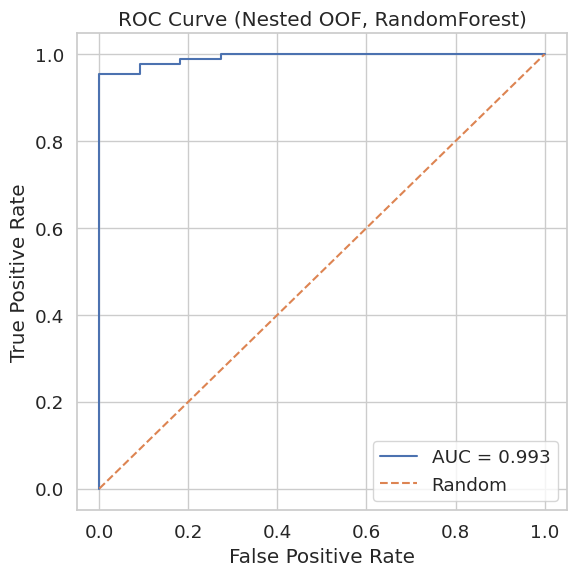

[INFO] ROC curve saved to: /content/drive/MyDrive/geoexosome_results/roc_curve_RandomForest_nested.png


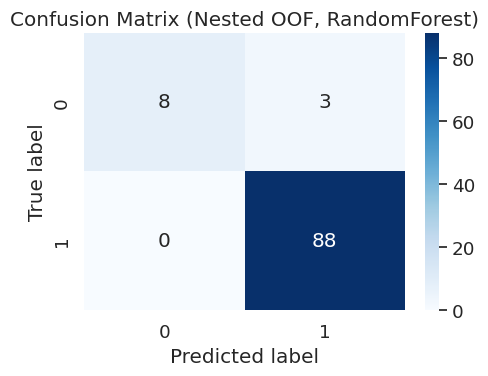

[INFO] Confusion matrix saved to: /content/drive/MyDrive/geoexosome_results/confusion_matrix_RandomForest_nested.png


In [8]:
# Cell 6:
# ROC curve and confusion matrix visualization for the selected model
# using the nested OOF predictions stored in Cell 4.

from sklearn.metrics import roc_curve

print("\n" + "=" * 70)
print(f"Out-of-fold performance summary for: {best_name}")
print("=" * 70)

y_true_best = oof_predictions[best_name]["y_true"]
y_proba_best = oof_predictions[best_name]["y_proba"]
y_pred_best = oof_predictions[best_name]["y_pred"]

auc_best = roc_auc_score(y_true_best, y_proba_best)
acc_best = accuracy_score(y_true_best, y_pred_best)
cm_best = confusion_matrix(y_true_best, y_pred_best)

print(f"OOF ROC-AUC: {auc_best:.4f}")
print(f"OOF Accuracy: {acc_best:.4f}")
print("Confusion matrix:")
print(cm_best)

# ROC curve
fpr, tpr, _ = roc_curve(y_true_best, y_proba_best)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_best:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Nested OOF, {best_name})")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(base_save_path, f"roc_curve_{best_name}_nested.png")
plt.savefig(roc_path, dpi=300)
plt.show()
print(f"[INFO] ROC curve saved to: {roc_path}")

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Nested OOF, {best_name})")
plt.tight_layout()

cm_path = os.path.join(base_save_path, f"confusion_matrix_{best_name}_nested.png")
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"[INFO] Confusion matrix saved to: {cm_path}")


In [9]:
# Cell 7:
# Random Forest-based feature importance and SHAP interpretation

print("\n" + "=" * 70)
print("Random Forest – feature importance and SHAP analysis")
print("=" * 70)

if "RandomForest" not in results:
    raise ValueError("RandomForest results are not available in 'results'.")

rf_params = results["RandomForest"]["best_params"]

rf_best = ImbPipeline([
    ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
    ("clf", RandomForestClassifier(
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        n_estimators=rf_params["clf__n_estimators"],
        max_depth=rf_params["clf__max_depth"],
        max_features=rf_params["clf__max_features"],
    ))
])

rf_best.fit(X, y)
rf_clf = rf_best.named_steps["clf"]


# 1) Probe-level feature importance from RF
rf_importances = rf_clf.feature_importances_
fi_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "RF_Importance": rf_importances
}).sort_values("RF_Importance", ascending=False)

if mapping_df is not None:
    fi_df = fi_df.merge(mapping_df, on="ProbeID", how="left")

fi_path = os.path.join(base_save_path, "rf_feature_importance_probes.csv")
fi_df.to_csv(fi_path, index=False)
print(f"[INFO] RF feature importance saved to: {fi_path}")

# 2) SHAP values for RF
print("\n[INFO] Computing SHAP values for Random Forest (TreeExplainer)...")

# RF pipeline does not include a scaler, so X is used directly
X_rf_input = X.copy()

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_rf_input)

# Find positive class index (should be 1)
pos_class_index = list(rf_clf.classes_).index(1)
shap_values_crc = shap_values[pos_class_index]


shap_importance = np.abs(shap_values_crc).mean(axis=0)

shap_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "SHAP_Importance": shap_importance
}).sort_values("SHAP_Importance", ascending=False)

if mapping_df is not None:
    shap_df = shap_df.merge(mapping_df, on="ProbeID", how="left")

shap_path = os.path.join(base_save_path, "rf_shap_importance_probes.csv")
shap_df.to_csv(shap_path, index=False)
print(f"[INFO] RF SHAP-based importance saved to: {shap_path}")

# 3) SHAP summary plot at probe level (top 20 features)
print("\n[INFO] Generating SHAP summary plot at probe level (top 20 features)...")

shap.summary_plot(
    shap_values_crc,
    X_rf_input,
    feature_names=feature_cols,
    max_display=20,
    show=False
)

plt.tight_layout()
summary_path = os.path.join(base_save_path, "rf_shap_summary_top20_probes.png")
plt.savefig(summary_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"[INFO] SHAP summary plot (probe level) saved to: {summary_path}")



Random Forest – feature importance and SHAP analysis
[INFO] RF feature importance saved to: /content/drive/MyDrive/geoexosome_results/rf_feature_importance_probes.csv

[INFO] Computing SHAP values for Random Forest (TreeExplainer)...


ValueError: All arrays must be of the same length

In [ ]:
# Cell 8 :
# Aggregate RF and SHAP importance at the miRNA level and visualize top miRNAs.

print("\n" + "=" * 70)
print("miRNA-level aggregation of RF and SHAP importance")
print("=" * 70)

if mapping_df is None:
    print("[WARNING] No probe → miRNA mapping available. Skipping miRNA-level analysis.")
else:
    # Ensure we only use rows with valid miRNA names
    fi_mi = (
        fi_df.dropna(subset=["miRNA"])
             .groupby("miRNA")["RF_Importance"]
             .agg(["count", "max", "sum", "mean"])
             .reset_index()
    )
    fi_mi.rename(columns={
        "count": "Num_Probes",
        "max": "RF_Max",
        "sum": "RF_Sum",
        "mean": "RF_Mean"
    }, inplace=True)

    shap_mi = (
        shap_df.dropna(subset=["miRNA"])
               .groupby("miRNA")["SHAP_Importance"]
               .agg(["max", "sum", "mean"])
               .reset_index()
    )
    shap_mi.rename(columns={
        "max": "SHAP_Max",
        "sum": "SHAP_Sum",
        "mean": "SHAP_Mean"
    }, inplace=True)

    miRNA_importance = fi_mi.merge(shap_mi, on="miRNA", how="left")

    # Rank by RF_Sum (primary ranking) as an example
    miRNA_importance = miRNA_importance.sort_values("RF_Sum", ascending=False)

    top_miRNAs = miRNA_importance.head(20).copy()

    agg_path = os.path.join(base_save_path, "miRNA_importance_aggregated.csv")
    miRNA_importance.to_csv(agg_path, index=False)

    top5_path = os.path.join(base_save_path, "miRNA_importance_top5.csv")
    top_miRNAs.head(5).to_csv(top5_path, index=False)

    print(f"[INFO] Full miRNA-level importance table saved to: {agg_path}")
    print(f"[INFO] Top 5 miRNAs saved to: {top5_path}")
    print("\nTop 5 miRNAs (by RF_Sum):")
    print(top_miRNAs.head(5))

    # Bar plot for top miRNAs (e.g. top 20 by RF_Sum)
    plt.figure(figsize=(8, 6))
    plt.barh(top_miRNAs["miRNA"], top_miRNAs["RF_Sum"])
    plt.gca().invert_yaxis()
    plt.xlabel("Aggregated RF importance (sum across probes)")
    plt.title("Top miRNAs ranked by RF feature importance")
    plt.tight_layout()

    mirna_bar_path = os.path.join(base_save_path, "miRNA_top20_RF_importance_barplot.png")
    plt.savefig(mirna_bar_path, dpi=300)
    plt.show()
    print(f"[INFO] miRNA-level RF importance bar plot saved to: {mirna_bar_path}")


In [ ]:
# Cell 9 :
# Save a structured summary of the analysis as JSON and a concise text summary
# for use in the manuscript and supplementary materials.

import json

print("\n" + "=" * 70)
print("Exporting final analysis summary (JSON and text)")
print("=" * 70)

summary = {
    "Dataset": {
        "GEO_ID": gse_id,
        "n_samples": int(df_expression.shape[0]),
        "n_features_probes": int(len(feature_cols)),
        "label_counts": {
            "class_0": int((y == 0).sum()),  # healthy controls
            "class_1": int((y == 1).sum())   # CRC patients
        }
    },
    "Model_Selection": {
        "outer_folds": outer_cv.get_n_splits(),
        "inner_folds": inner_cv.get_n_splits(),
        "candidates": list(results.keys())
    },
    "Best_Model": {
        "name": best_name,
        "params": results[best_name]["best_params"],
        "oof_auc": float(results[best_name]["oof_auc"]),
        "oof_accuracy": float(results[best_name]["oof_accuracy"]),
        "confusion_matrix": results[best_name]["confusion_matrix"],
        "train_auc_mean": float(train_auc_mean),
        "test_auc_mean": float(test_auc_mean)
    }
}

if mapping_df is not None:
    # Include top 5 miRNAs if available
    try:
        summary["Top_miRNAs"] = top_miRNAs.head(5).to_dict(orient="records")
    except NameError:
        pass

json_path = os.path.join(base_save_path, "final_research_results_nested.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

# Create a concise text summary suitable for manuscript or supplementary file
txt_lines = []
txt_lines.append(f"GEO dataset: {gse_id}")
txt_lines.append(f"Number of samples: {summary['Dataset']['n_samples']}")
txt_lines.append(f"Number of probes (features): {summary['Dataset']['n_features_probes']}")
txt_lines.append(f"Label counts (0: healthy, 1: CRC): {summary['Dataset']['label_counts']}")
txt_lines.append("")
txt_lines.append(f"Candidate models: {', '.join(summary['Model_Selection']['candidates'])}")
txt_lines.append(f"Best model (nested CV): {best_name}")
txt_lines.append(f"Nested OOF ROC-AUC: {summary['Best_Model']['oof_auc']:.4f}")
txt_lines.append(f"Nested OOF Accuracy: {summary['Best_Model']['oof_accuracy']:.4f}")
txt_lines.append(f"Mean Train ROC-AUC (outer CV): {summary['Best_Model']['train_auc_mean']:.4f}")
txt_lines.append(f"Mean Test  ROC-AUC (outer CV): {summary['Best_Model']['test_auc_mean']:.4f}")

if "Top_miRNAs" in summary:
    txt_lines.append("\nTop miRNAs (aggregated RF + SHAP, example ranking):")
    for row in summary["Top_miRNAs"]:
        mi_name = row.get("miRNA", "NA")
        rf_sum = row.get("RF_Sum", np.nan)
        shap_sum = row.get("SHAP_Sum", np.nan)
        txt_lines.append(f" - {mi_name}: RF_Sum={rf_sum:.4f}, SHAP_Sum={shap_sum:.4f}")

txt_path = os.path.join(base_save_path, "research_summary_nested_for_manuscript.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(txt_lines))

print(f"[INFO] Final JSON summary saved to: {json_path}")
print(f"[INFO] Text summary saved to: {txt_path}")
print("=" * 70)
